# Hierarchical clustering

## Setup

In [ ]:
#| default_exp clustering

In [ ]:
#| export
import pandas as pd,numpy as np
from katlas.core import *
from tqdm import tqdm
from functools import partial
from tqdm.contrib.concurrent import process_map
from fastcore.meta import delegates
from scipy.cluster.hierarchy import linkage, fcluster,dendrogram
from matplotlib import pyplot as plt

In [ ]:
#| hide
#| export
EPSILON = 1e-8

## JS divergence

The Jensen-Shannon divergence between two probability distributions $ P $ and $ Q $ is defined as:

$$
\mathrm{JS}(P \| Q) = \frac{1}{2} \, \mathrm{KL}(P \| M) + \frac{1}{2} \, \mathrm{KL}(Q \| M)
$$

where $ M = \frac{1}{2}(P + Q) $ is the average (mixture) distribution, and $ \mathrm{KL} $ denotes the Kullback–Leibler divergence:

$$
\mathrm{KL}(P \| Q) = \sum_{x \in \mathcal{X}} P(x) \log \left( \frac{P(x)}{Q(x)} \right)
$$

Therefore,

$$
\mathrm{JS}(P \| Q) = \frac{1}{2} \sum_{x \in \mathcal{X}} P(x) \log \left( \frac{P(x)}{M(x)} \right) + \frac{1}{2} \sum_{x \in \mathcal{X}} Q(x) \log \left( \frac{Q(x)}{M(x)} \right)
$$

In [ ]:
#| export
def js_divergence(p1, # pssm 
                  p2, # pssm
                  mean=True):
    "p1 and p2 are two arrays (df or np) with index as aa and column as position"
    assert p1.shape==p2.shape
    mask = (p1 + p2) > 0 #skip those with double 0
    p1,p2 = p1[mask], p2[mask]
    
    m = 0.5 * (p1 + p2)
    js = 0.5 * np.sum(p1 * np.log(p1 / m + EPSILON), axis=0) + \
         0.5 * np.sum(p2 * np.log(p2 / m + EPSILON), axis=0)
    return np.mean(js) if mean else js

Let $P_i(x)$ and $Q_i(x)$ be the probability of amino acid $x$ at position $i$ in the two PSSMs, and define the average distribution:

$$
M_i(x) = \frac{1}{2} \left( P_i(x) + Q_i(x) \right)
$$

Then the Jensen–Shannon divergence at position $i$ is:

$$
\mathrm{JS}_i(P_i \| Q_i) = \frac{1}{2} \sum_{x} P_i(x) \log \left( \frac{P_i(x)}{M_i(x) + \varepsilon} \right) + \frac{1}{2} \sum_{x} Q_i(x) \log \left( \frac{Q_i(x)}{M_i(x) + \varepsilon} \right)
$$

where $\varepsilon = 10^{-8}$ is a small constant added for numerical stability.

If averaging across positions, the full divergence is:

$$
\mathrm{JS}(P \| Q) = \frac{1}{L} \sum_{i=1}^{L} \mathrm{JS}_i(P_i \| Q_i)
$$

where $L$ is the number of positions (i.e., columns in the PSSM).

In [ ]:
pssms = Data.get_pspa_all_scale()

In [ ]:
# one example
pssm_df = recover_pssm(pssms.iloc[1])

In [ ]:
js_divergence(pssm_df,pssm_df)

np.float64(9.999929889226068e-09)

In [ ]:
#| export
def js_divergence_flat(p1_flat, # pd.Series of flattened pssm
                       p2_flat, # pd.Series of flattened pssm
                       ):

    "p1 and p2 are two flattened pd.Series with index as aa and column as position"

    js = js_divergence(p1_flat,p2_flat,mean=False)
    total_position = len(p1_flat.index.str.extract(r'(-?\d+)').drop_duplicates())
    return js/total_position

In [ ]:
pssm_flat = pssms.iloc[1]

In [ ]:
pssm_flat

-5P    0.02971
-5G    0.03443
-5A    0.04180
-5C    0.03500
-5S    0.04137
        ...   
4D     0.04693
4E     0.04693
4pS    0.05155
4pT    0.05155
4pY    0.04319
Name: ACVR2A, Length: 230, dtype: float64

In [ ]:
js_divergence(pssm_flat,pssm_flat)

np.float64(9.999929889226066e-08)

In [ ]:
#| export
def get_1d_distance(df,func_flat):
    "Compute 1D distance for each row in a dataframe given a distance function "
    n = len(df)
    dist = []
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            d = func_flat(df.iloc[i], df.iloc[j])
            dist.append(d)
    return np.array(dist)

In [ ]:
# return 1d distance matrix
get_1d_distance(pssms.head(),js_divergence_flat)

100%|████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 288.92it/s]


array([0.08286125, 0.08577978, 0.08798376, 0.08501009, 0.00215832,
       0.07937984, 0.07066437, 0.08348296, 0.07361695, 0.0042525 ])

In [ ]:
#| export
def get_1d_js(df): 
    "Compute 1D distance using JS divergence."
    return get_1d_distance(df,js_divergence_flat)

In [ ]:
distance = get_1d_js(pssms.head(20))

100%|███████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 70.04it/s]


Parallel computing to accelerate when flattened pssms are too many in a df:

In [ ]:
#| hide
#| export
def get_distance(pair, df, func):
    i, j = pair
    return func(df.iloc[i], df.iloc[j])

In [ ]:
#| export
def get_1d_distance_parallel(df, func_flat, max_workers=4, chunksize=100):
    "Parallel compute 1D distance for each row in a dataframe given a distance function "
    n = len(df)
    index_pairs = [(i, j) for i in range(n) for j in range(i + 1, n)]

    bound_worker = partial(get_distance, df=df, func=func_flat)

    dist = process_map(bound_worker, index_pairs, max_workers=max_workers, chunksize=chunksize)
    return np.array(dist)

```python
get_1d_distance_parallel(pssms.head(),js_divergence_flat)
```

In [ ]:
#| export
@delegates(get_1d_distance_parallel)
def get_1d_js_parallel(df, func_flat=js_divergence_flat, **kwargs): 
    "Compute 1D distance matrix using JS divergence."
    return get_1d_distance_parallel(df, func_flat=func_flat, **kwargs)

```python
get_1d_js_parallel(pssms.head())
```

In [ ]:
#| export
def get_Z(pssms,func_flat=js_divergence_flat,parallel=True):
    "Get linkage matrix Z from pssms dataframe"
    distance = get_1d_distance_parallel(pssms,func_flat=func_flat) if parallel else get_1d_distance(pssms,func_flat=func_flat)
    Z = linkage(distance, method='ward')
    return Z

In [ ]:
Z = get_Z(pssms.head(10),parallel=False)

100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 144.78it/s]


In [ ]:
Z[:5]

array([[1.00000000e+00, 2.00000000e+00, 2.15831826e-03, 2.00000000e+00],
       [3.00000000e+00, 4.00000000e+00, 4.25249802e-03, 2.00000000e+00],
       [5.00000000e+00, 1.10000000e+01, 4.65130789e-03, 3.00000000e+00],
       [6.00000000e+00, 7.00000000e+00, 5.89059774e-03, 2.00000000e+00],
       [1.00000000e+01, 1.30000000e+01, 9.31412264e-03, 4.00000000e+00]])

In [ ]:
#| export
def plot_dendrogram(Z,
                    color_thr=0.07,
                    dense=7, # the higher the more dense for each row
                    line_width=1,
                    **kwargs):
    length = (len(Z) + 1) // dense
    
    plt.figure(figsize=(5,length))
    with plt.rc_context({'lines.linewidth': line_width}):
        dendrogram(
            Z,
            orientation='left',
            leaf_font_size=7,
            color_threshold=color_thr,
            **kwargs
        )
    plt.title('Hierarchical Clustering Dendrogram')
    plt.ylabel('Distance')
    # plt.savefig(output, bbox_inches='tight')
    # plt.close()
    ax = plt.gca()
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(False)

In [ ]:
set_sns(100)

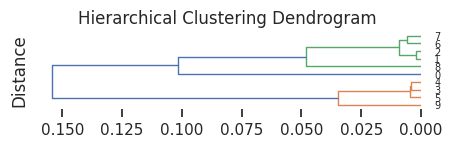

In [ ]:
plot_dendrogram(Z,dense=7,line_width=1)

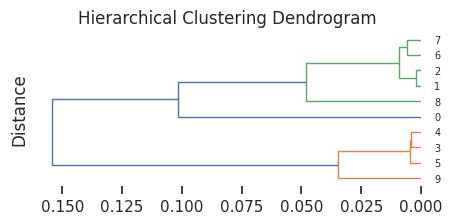

In [ ]:
plot_dendrogram(Z,dense=4)

In [ ]:
#| export
def pssm_to_seq(pssm_df, 
                thr=0.2, # threshold of probability to show in sequence
                clean_center=True, # if true, zero out non-last three values in position 0 (keep only s,t,y values at center)
                ):
    "Represent PSSM in string sequence of amino acids"
    
    pssm_df = pssm_df.copy()
    if clean_center:
        pssm_df.loc[pssm_df.index[:-3], 0] = 0  # keep only s,t,y in center 0 position

    pssm_df.index = pssm_df.index.map(lambda x: x.replace('pS', 's').replace('pT', 't').replace('pY', 'y'))

    consensus = []
    for i, col in enumerate(pssm_df.columns):
        # consider the case where sum for the position is 0
        column_vals = pssm_df[col]
        if column_vals.sum() == 0:
            symbol = '_'
        else:
            top = column_vals.nlargest(3)
            passing = [aa for aa, prob in zip(top.index, top.values) if prob > thr]

            if not passing:
                symbol = '.'
            elif len(passing) == 1:
                symbol = passing[0]
            else:
                symbol = f"[{'/'.join(passing)}]"
                
        if col == 0:  # center position
            if symbol.startswith('['):
                symbol = symbol[:-1] + ']*'
            else:
                symbol += '*'

        consensus.append(symbol)

    return ''.join(consensus)

In [ ]:
pssm_to_seq(pssm_df,thr=0.1)

'...[E/D].[t/s]*[s/t]...'

In [ ]:
#| export
def get_pssm_seq_labels(pssms,
                        count_map=None, # df index as key, counts as value
                        thr=0.2, # threshold of probability to show in sequence
                       ):
    "Use index of pssms and the pssm to seq to represent pssm."
    if count_map is not None:
        labels=[str(i)+f' (n={count_map[i]:,})' + ': '+pssm_to_seq(recover_pssm(r),0.2) for i,r in pssms.iterrows()]
    else:
        labels=[str(i)+ ': '+pssm_to_seq(recover_pssm(r),thr) for i,r in pssms.iterrows()]

    return labels

In [ ]:
get_pssm_seq_labels(pssms.head(10))

['AAK1: .....t*G...',
 'ACVR2A: ...E.[t/s]*....',
 'ACVR2B: ...E.[t/s]*....',
 'AKT1: ..RR.[s/t]*....',
 'AKT2: ..RR.[s/t]*....',
 'AKT3: ..RR.[s/t]*....',
 'ALK2: ...E.[t/s]*....',
 'ALK4: ...E.[t/s]*....',
 'ALPHAK3: ....yt*....',
 'AMPKA1: .....[s/t]*....']

In [ ]:
import random

In [ ]:
# get a dict of index and counts

count_dict = {idx:random.randint(1,100) for idx in pssms.head(10).index}

In [ ]:
labels= get_pssm_seq_labels(pssms.head(10),count_dict)
labels

['AAK1 (n=86): .....t*G...',
 'ACVR2A (n=41): ...E.[t/s]*....',
 'ACVR2B (n=95): ...E.[t/s]*....',
 'AKT1 (n=97): ..RR.[s/t]*....',
 'AKT2 (n=38): ..RR.[s/t]*....',
 'AKT3 (n=18): ..RR.[s/t]*....',
 'ALK2 (n=91): ...E.[t/s]*....',
 'ALK4 (n=41): ...E.[t/s]*....',
 'ALPHAK3 (n=40): ....yt*....',
 'AMPKA1 (n=67): .....[s/t]*....']

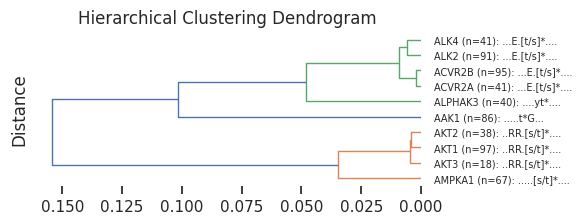

In [ ]:
plot_dendrogram(Z,dense=4,labels=labels)

## Full pipeline

In [ ]:
#| eval: false
# get distance matrix
pssms=pssms.head(100)

Z = get_Z(pssms)

# optional, get counts for each index
# count_dict = pssms.index.value_counts()

# get pssm to seq labels with counts
# labels= get_pssm_seq_labels(pssms,count_dict)

# or get pssm to seq labels only
labels= get_pssm_seq_labels(pssms)

  0%|          | 0/4950 [00:00<?, ?it/s]

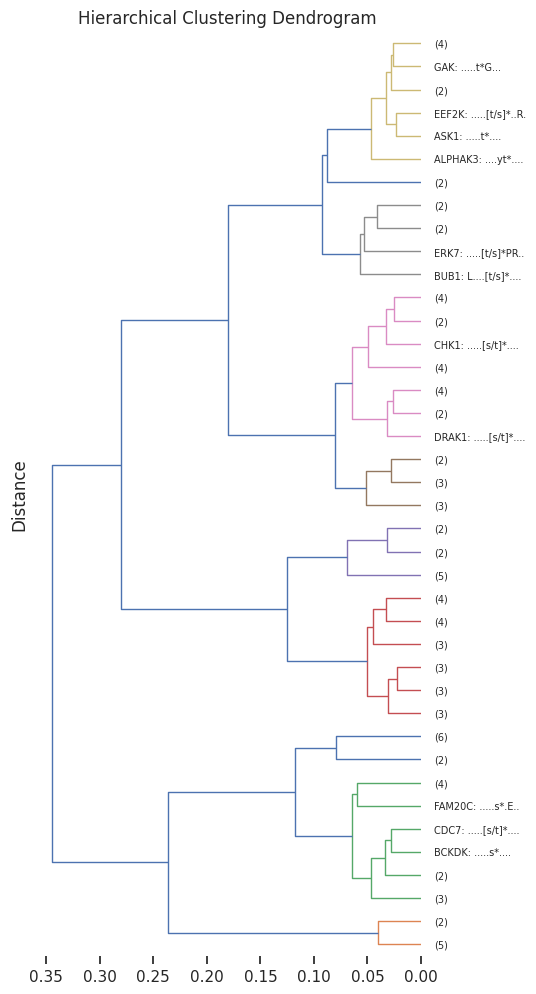

In [ ]:
# plot dendrogram
plot_dendrogram(Z,dense=8,labels=labels,truncate_mode='lastp', p=40) # only show 40

# save
# save_pdf('dendrogram.pdf')

## End

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()